# AirBnB Pricing Tool for Seattle listings
This notebook will focus on data pre-processing and exploratory analysis, including:
1. Get and clean available data
2. Merge related tables
3. Exploratory analysis

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

In [92]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [93]:
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score

import xgboost as xgb
from xgboost import plot_importance

%matplotlib inline

In [4]:
# read files downloaded from insideairbnb
listing = pd.read_csv('data/listings.csv.gz', compression='gzip', header=0)
review = pd.read_csv('data/reviews.csv.gz', compression='gzip', header=0)
calendar = pd.read_csv('data/calendar.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
neighbour = pd.read_csv('data/neighbourhoods.csv')
geo = gpd.read_file('data/neighbourhoods.geojson')
# read files from seattle transportation(maybe not for now)
#parking = pd.read_csv('2020_Paid_Parking_Occupancy__Year-to-date_.csv')

In [5]:
listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20200617132702,2020-06-17,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, Dutch Colonial ...","This beautiful, gracious home has been complet...","Gorgeous, architect remodeled, Dutch Colonial ...",none,Madrona is a hidden gem of a neighborhood. It ...,"We adhere to a 10pm -9am quiet hour schedule, ...",NaN,Guests can access any part of the house.,We are a family who live next door and are ava...,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/02973ad3-a...,NaN,2536,https://www.airbnb.com/users/show/2536,Megan,2008-08-26,"Seattle, Washington, United States",I welcome guests from all walks of life and ev...,within an hour,89%,87%,t,https://a0.muscache.com/im/pictures/user/016a1...,https://a0.muscache.com/im/pictures/user/016a1...,Minor,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,f,"Seattle, WA, United States",Madrona,Madrona,Central Area,Seattle,WA,98122,Seattle,"Seattle, WA",US,United States,47.61082,-122.29082,t,House,Entire home/apt,9,2.5,4.0,4.0,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",NaN,$296.00,NaN,NaN,$500.00,$250.00,8,$25.00,1,1125,1,1,1125,1125,1.0,1125.0,3 weeks ago,t,0,0,14,30,2020-06-17,32,6,2008-09-15,2020-02-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,STR-OPLI-19-002837,"{WASHINGTON,"" Seattle"","" WA""}",t,f,strict_14_with_grace_period,f,f,2,2,0,0,0.22
1,9419,https://www.airbnb.com/rooms/9419,20200617132702,2020-06-18,Glorious sun room w/ memory foambed,"Keeping you safe is our priority, we are adher...",Our new Sunny space has a private room from th...,"Keeping you safe is our priority, we are adher...",none,"Lots of restaurants (see our guide book) bars,...","This area is an arts district,you will see all...",Car 2 go is in this neigborhood Bus is across ...,"24 /7 access kitchen, bathroom and community s...",I have a hands on warm approach to guests but ...,"No drugs,no smoking inside *outside in front o...",NaN,NaN,https://a0.muscache.com/im/pictures/56645186/e...,NaN,30559,https://www.airbnb.com/users/show/30559,Angielena,2009-08-09,"Seattle, Washington, United States",I am a visual artist who is the director of ...,within a few hours,100%,90%,t,https://a0.muscache.com/im/users/30559/profile...,

## Column Filtering

In [6]:
listing.shape

(6575, 106)

In [7]:
listing.isna().sum()

id                                                 0
listing_url                                        0
scrape_id                                          0
last_scraped                                       0
name                                               0
summary                                          134
space                                           1083
description                                       35
experiences_offered                                0
neighborhood_overview                           1700
notes                                           2555
transit                                         1818
access                                          2099
interaction                                     1615
house_rules                                     1457
thumbnail_url                                   6575
medium_url                                      6575
picture_url                                        0
xl_picture_url                                

In [8]:
selected_cols = ['listing_url', 'id', 'name', 'summary', 'space', 'description', 'neighborhood_overview',
 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_since', 'host_response_time',
 'host_response_rate','host_is_superhost', 'host_total_listings_count',
 'neighbourhood_cleansed', 'latitude', 'longitude',
 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities',
 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
 'has_availability', 'availability_30', 'availability_60', 'availability_90','availability_365',
 'number_of_reviews', 'number_of_reviews_ltm',
 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
 'review_scores_communication', 'review_scores_location', 'review_scores_value',
 'instant_bookable', 'cancellation_policy', 'reviews_per_month']

listing = listing[selected_cols]
listing_text = listing.iloc[:, 1:12] #text based dataframe for NLP analysis
listing.drop(listing.columns[2:12], axis=1, inplace=True) #drop the text columns

In [9]:
listing.shape

(6575, 44)

In [10]:
listing.head()

,listing_url,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
0,https://www.airbnb.com/rooms/2318,2318,2008-08-26,within an hour,89%,t,2.0,Madrona,47.61082,-122.29082,House,Entire home/apt,9,2.5,4.0,4.0,Real Bed,"{Internet,Wifi,Kitchen,""Free parking on premis...",$296.00,$500.00,$250.00,8,$25.00,1,1125,t,0,0,14,30,32,6,2008-09-15,2020-02-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,0.22
1,https://www.airbnb.com/rooms/9419,9419,2009-08-09,within a few hours,100%,t,8.0,Georgetown,47.55017,-122.31937,Apartment,Private room,2,3.0,1.0,2.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,""Fre...",$62.00,$100.00,$20.00,1,$15.00,2,180,t,30,60,90,365,148,14,2010-07-30,2019-12-27,93.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,1.23
2,https://www.airbnb.com/rooms/9531,9531,2009-08-13,within a few hours,100%,t,2.0,Fairmount Park,47.55539,-122.38474,House,Entire home/apt,4,1.0,2.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",$165.00,$400.00,$120.00,2,$10.00,3,730,t,0,0,15,290,40,4,2012-01-12,2019-12-30,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,0.39
3,https://www.airbnb.com/rooms/9534,9534,2009-08-13,within a few hours,100%,t,2.0,Fairmount Park,47.55624,-122.38598,Guest suite,Entire home/apt,3,1.0,2.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",$125.00,$400.00,$95.00,2,$5.00,2,365,t,1,2,18,293,50,9,2012-01-15,2020-05-17,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,0.49
4,https://www.airbnb.com/rooms/9596,9596,2009-04-26,within a few hours,90%,f,5.0,Wallingford,47.65479,-122.33652,Apartment,Entire home/apt,4,1.0,1.0,4.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free str...",$120.00,$200.00,$85.00,2,$15.00,30,60,t,8,26,56,56,93,13,2011-06-15,2019-09-22,91.0,9.0,9.0,10.0,9.0,10.0,9.0,f,strict_14_with_grace_period,0.85


### Description of each column:

- host_since - date that the host first joined Airbnb
- host_response_time - average amount of time the host takes to reply to messages
- host_response_rate - proportion of messages that the host replies to
- host_is_superhost - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
- host_listings_count - how many listings the host has in total
- host_identity_verified - whether or not the host has been verified with id
- neighbourhood_cleansed - the London borough the property is in
- property_type - type of property, e.g. house or flat
- room_type - type of listing, e.g. entire home, private room or shared room
- accommodates - how many people the property accommodates
- bathrooms - number of bathrooms
- bedrooms - number of bedrooms
- beds - number of beds
- bed_type - type of bed, e.g. real bed or sofa-bed
- amenities - list of amenities
- price - nightly advertised price (the target variable)
- security_deposit - the amount required as a security deposit
- cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
- guests_included - the number of guests included in the booking fee
- extra_people - the price per additional guest above the guests_included price
- minimum_nights - the minimum length of stay
- maximum_nights - the maximum length of stay
- availability_30 - how many nights are available to be booked in the next 30 days
- availability_60 - how many nights are available to be booked in the next 60 days
- availability_90 - how many nights are available to be booked in the next 90 days
- availability_365 - how many nights are available to be booked in the next 365 days
- number_of_reviews - the number of reviews left for the property
- number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
- first_review - the date of the first review
- last_review - the date of the most recent review
- review_scores_rating - guests can score properties overall from 1 to 5 stars
- review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
- review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
- review_scores_checkin - guests can score their check-in from 1 to 5 stars
- review_scores_communication - guests can score a host's communication from 1 to 5 stars
- review_scores_location - guests can score a property's location from 1 to 5 stars
- review_scores_value - guests can score a booking's value for money from 1 to 5 stars
- instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)
- cancellation_policy - the type of cancellation policy, e.g. strict or moderate
- reviews_per_month - calculated field of the average number of reviews left by guest each month

### Cleaning individual columns

#### host_since
This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped(June 20th, 2020). The original column will be left in initially for EDA, and dropped later

In [11]:
# Converting to datetime
listing.host_since = pd.to_datetime(listing.host_since)

# Calculating the number of days
listing['host_day_active'] = (datetime(2020, 6, 20) - listing.host_since).astype('timedelta64[D]')

In [12]:
# Printing mean and median
print("Average days being a host:", round(listing['host_day_active'].mean(),0))
print("Median days being a host:", listing['host_day_active'].median())

# Replacing null values with the median
listing.host_day_active.fillna(listing.host_day_active.median(), inplace=True)

Average days being a host: 1868.0
Median days being a host: 1872.5


#### host_response time

In [13]:
listing.host_response_time.isna().sum()

2080

In [14]:
listing.host_response_time.fillna('unknown', inplace=True)
listing.host_response_time.value_counts(normalize=True)

within an hour        0.494449
unknown               0.316350
within a few hours    0.100380
within a day          0.070570
a few days or more    0.018251
Name: host_response_time, dtype: float64

#### host_response_rate

In [15]:
listing.host_response_rate.isna().sum()

2080

In [16]:
listing.host_response_rate.value_counts(normalize=True)

100%    0.737709
97%     0.066296
98%     0.026251
90%     0.019577
75%     0.018020
89%     0.016685
99%     0.014683
0%      0.012236
50%     0.009789
71%     0.008009
94%     0.007119
39%     0.006897
67%     0.005562
83%     0.004672
86%     0.004227
92%     0.004227
80%     0.004004
96%     0.003782
88%     0.003560
70%     0.003337
95%     0.003337
56%     0.003115
91%     0.003115
45%     0.002447
40%     0.001780
93%     0.001557
73%     0.001335
33%     0.000667
76%     0.000667
60%     0.000667
20%     0.000667
25%     0.000667
63%     0.000445
85%     0.000445
14%     0.000445
10%     0.000445
82%     0.000445
78%     0.000445
13%     0.000222
68%     0.000222
17%     0.000222
Name: host_response_rate, dtype: float64

In [17]:
# Removing the % sign and converting it to numbers
listing.host_response_rate = listing.host_response_rate.str[:-1].astype('float64')

# Bin into four categories
listing.host_response_rate = pd.cut(listing.host_response_rate, bins=[0, 50, 90, 99, 100], 
                                    labels = ['0-49%', '50-89%', '90-99%', '100%'], include_lowest = True).astype('str')

In [18]:
# Replacing the nan with 'unknown'
listing.host_response_rate.replace('nan', 'unknown', inplace=True)

listing.host_response_rate.value_counts()

100%       3316
unknown    2080
90-99%      586
50-89%      429
0-49%       164
Name: host_response_rate, dtype: int64

#### Price conversion - price, security_deposit, cleaning_fee, extra_people

In [19]:
listing.price = listing.price.replace('[\$,]', '', regex=True).astype(float)
listing.security_deposit = listing.security_deposit.replace('[\$,]', '', regex=True).astype(float)
listing.cleaning_fee = listing.cleaning_fee.replace('[\$,]', '', regex=True).astype(float)
listing.extra_people = listing.extra_people.replace('[\$,]', '', regex=True).astype(float)

In [20]:
listing.security_deposit.fillna(0, inplace=True)
listing.cleaning_fee.fillna(0, inplace=True)
listing.extra_people.fillna(0, inplace=True)

In [21]:
listing['price'].describe()

count     6575.000000
mean       159.720152
std        308.683097
min          0.000000
25%         78.500000
50%        113.000000
75%        180.000000
max      10000.000000
Name: price, dtype: float64

#### property_type

In [22]:
listing.property_type.value_counts()

House                 2142
Apartment             1901
Guest suite            773
Townhouse              492
Condominium            442
Serviced apartment     247
Guesthouse             223
Boutique hotel          64
Loft                    62
Bungalow                57
Cottage                 47
Tiny house              15
Bed and breakfast       14
Other                   12
Houseboat               11
Villa                   11
Boat                    11
Aparthotel              10
Camper/RV                9
Cabin                    9
Dome house               7
Tent                     4
Hostel                   3
Yurt                     2
Earth house              2
Nature lodge             1
Resort                   1
Chalet                   1
In-law                   1
Treehouse                1
Name: property_type, dtype: int64

In [23]:
# Replacing categories that are types of houses or apartments
listing.property_type.replace({
    'Townhouse': 'House',
    'Condominium': 'Apartment',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House',
    'Cabin': 'House',
}, inplace=True)

# Replacing other categories with 'other'
listing.loc[~listing.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

#### bathrooms, bedrooms and beds
Replacing missing values with the median

In [24]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    listing[col].fillna(listing[col].median(), inplace=True)

#### bed_type
Drop bed_type column as most of the rows are real bed

In [25]:
listing.bed_type.value_counts()

Real Bed         6503
Futon              34
Pull-out Sofa      22
Airbed             13
Couch               3
Name: bed_type, dtype: int64

In [26]:
listing.drop('bed_type', axis=1, inplace=True)

#### Handle amenities

In [27]:
listing.amenities

0       {Internet,Wifi,Kitchen,"Free parking on premis...
1       {Internet,Wifi,"Air conditioning",Kitchen,"Fre...
2       {TV,"Cable TV",Internet,Wifi,"Wheelchair acces...
3       {TV,"Cable TV",Internet,Wifi,Kitchen,"Free par...
4       {TV,"Cable TV",Internet,Wifi,Kitchen,"Free str...
                              ...                        
6570    {TV,Wifi,Kitchen,"Paid parking off premises","...
6571    {TV,Wifi,"Air conditioning",Kitchen,Heating,"S...
6572    {TV,Wifi,"Free street parking","Hot tub","Indo...
6573    {TV,Wifi,"Air conditioning",Kitchen,Heating,"S...
6574    {TV,Wifi,Kitchen,"Free parking on premises",Br...
Name: amenities, Length: 6575, dtype: object

In [28]:
def get_num_amenities(s):
    return len(s.split(','))

listing['num_amenities'] = listing['amenities'].apply(get_num_amenities)

In [29]:
# Creating a set of all possible amenities
amen_list = list(listing.amenities)
amen_list_str = " ".join(amen_list)
amen_list_str = amen_list_str.replace('{', '')
amen_list_str = amen_list_str.replace('}', ',')
amen_list_str = amen_list_str.replace('"', '')

amen_set = [x.strip() for x in amen_list_str.split(',')]
amen_set = set(amen_set)
amen_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Amazon Echo',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Baking sheet',
 'Balcony',
 'Barbecue utensils',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Bread maker',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide alarm',
 'Cat(s)',
 'Ceiling fan',
 'Central air conditioning',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 

In the list above, not every one will be important to increase the price of a list. Based on some research into amenities are considered by guests to be more important, a selection of the more important amenities will be extracted, and to be further investigated in the EDA section.

The amenities chosen are (slashes indicate separate categories that can be combined):
- 24-hour check-in
- Air conditioning/central air conditioning
- Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics)
- BBQ grill/fire pit/propane barbeque
- Balcony/patio or balcony
- Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
- Bed linens
- Breakfast
- Cable TV/TV
- Coffee maker/espresso machine
- Cooking basics
- Dishwasher/Dryer/Washer/Washer and dryer
- Elevator
- Exercise equipment/gym/private gym/shared gym
- Family/kid friendly, or anything containing 'children'
- Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
- Garden or backyard/outdoor seating/sun loungers/terrace
- Host greets you
- Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
- Internet/pocket wifi/wifi
- Long term stays allowed
- Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
- Private entrance
- Safe/security system
- Self check-in
- Smoking allowed
- Step-free access/wheelchair accessible, or anything containing 'accessible'
- Suitable for events

In [30]:
listing.loc[listing['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
listing.loc[listing['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
listing.loc[listing['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
listing.loc[listing['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
listing.loc[listing['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
listing.loc[listing['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
listing.loc[listing['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
listing.loc[listing['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
listing.loc[listing['amenities'].str.contains('TV'), 'tv'] = 1
listing.loc[listing['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
listing.loc[listing['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
listing.loc[listing['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'dishwasher'] = 1
listing.loc[listing['amenities'].str.contains('Elevator'), 'elevator'] = 1
listing.loc[listing['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
listing.loc[listing['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
listing.loc[listing['amenities'].str.contains('parking'), 'parking'] = 1
listing.loc[listing['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
listing.loc[listing['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
listing.loc[listing['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
listing.loc[listing['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
listing.loc[listing['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
listing.loc[listing['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
listing.loc[listing['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
listing.loc[listing['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
listing.loc[listing['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
listing.loc[listing['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
listing.loc[listing['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
listing.loc[listing['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

In [31]:
# Replacing nulls with zeros for new columns
listing[listing.iloc[:,45:].columns] = listing[listing.iloc[:,45:].columns].fillna(0)
# Create a list of amenity features where one category contains fewer than 10% of listings
infrequent_amenities = []
for col in listing.iloc[:,45:].columns:
    if listing[col].sum() < len(listing)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

['high_end_electronics', 'nature_and_views', 'breakfast', 'host_greeting', 'hot_tub_sauna_or_pool', 'smoking_allowed', 'accessible', 'event_suitable']


In [32]:
# Dropping infrequent amenity features
listing.drop(infrequent_amenities, axis=1, inplace=True)
# Dropping the original amenity column
listing.drop('amenities', axis=1, inplace=True)

In [33]:
listing.columns

Index(['listing_url', 'id', 'host_since', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'host_total_listings_count',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'reviews_per_month', 'host_day_active',
       'num_amenities', 'check_in_24h', 'air_conditioning', 'bbq', 'balcony',
       'bed_lin

#### availability
There are multiple measures of the same thing, so we will drop some of them to just leave monthly available and yearly available

In [34]:
listing.drop(['availability_60', 'availability_90'], axis=1, inplace=True)

#### first_review and last_review

In [35]:
print("Null values in 'first_review': {}%".format(round(100*listing.first_review.isna().sum()/len(listing),1)))
print("Null values in 'review_scores_rating': {}%".format(round(100*listing.review_scores_rating .isna().sum()/len(listing),1)))

Null values in 'first_review': 13.3%
Null values in 'review_scores_rating': 13.9%


In [36]:
listing.first_review = pd.to_datetime(listing.first_review) # Converting to datetime
# Calculating the number of days between the first review and the date the data was scraped
listing['time_since_first_review'] = (datetime(2020, 6, 20) - listing.first_review).astype('timedelta64[D]')

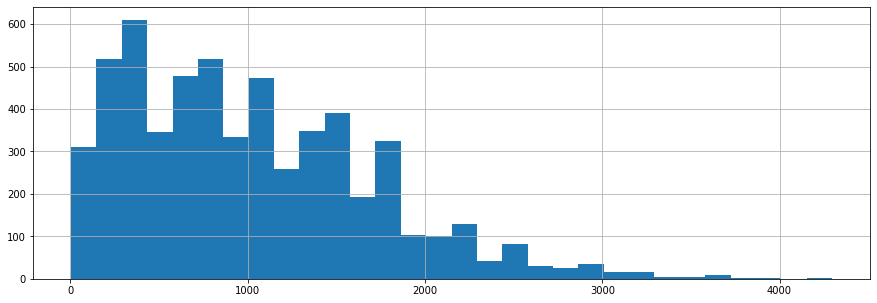

In [37]:
# Distribution of the number of days since first review
listing.time_since_first_review.hist(figsize=(15,5), bins=30)

In [38]:
def bin_column(col, bins, labels, na_label):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    listing[col] = pd.cut(listing[col], bins=bins, labels=labels, include_lowest=True)
    listing[col] = listing[col].astype('str')
    listing[col].replace('nan',na_label, inplace=True)
    

In [39]:
# Binning time since first review
bin_column(col = 'time_since_first_review',
           bins=[0, 182, 365, 730, 1825, max(listing.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-5 years',
                   '5+ years'],
           na_label = 'no reviews')

In [40]:
# Same transition for last_review
listing.last_review = pd.to_datetime(listing.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
listing['time_since_last_review'] = (datetime(2020, 6, 20) - listing.last_review).astype('timedelta64[D]')

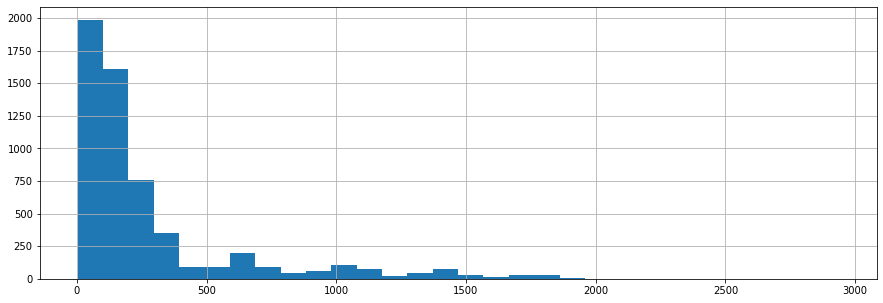

In [41]:
# Distribution of the number of days since last review
listing.time_since_last_review.hist(figsize=(15,5), bins=30);

In [42]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(listing.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [43]:
# Dropping last_review - first_review will be kept for EDA and dropped later
listing.drop('last_review', axis=1, inplace=True)

In [44]:
listing.head()

,listing_url,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,has_availability,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month,host_day_active,num_amenities,check_in_24h,air_conditioning,bbq,balcony,bed_linen,tv,coffee_machine,cooking_basics,dishwasher,elevator,gym,child_friendly,parking,outdoor_space,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,time_since_first_review,time_since_last_review
0,https://www.airbnb.com/rooms/2318,2318,2008-08-26,within an hour,50-89%,t,2.0,Madrona,47.61082,-122.29082,House,Entire home/apt,9,2.5,4.0,4.0,296.0,500.0,250.0,8,25.0,1,1125,t,0,30,32,6,2008-09-15,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,strict_14_with_grace_period,0.22,4316.0,39,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,5+ years,2-6 months
1,https://www.airbnb.com/rooms/9419,9419,2009-08-09,within a few hours,100%,t,8.0,Georgetown,47.55017,-122.31937,Apartment,Private room,2,3.0,1.0,2.0,62.0,100.0,20.0,1,15.0,2,180,t,30,365,148,14,2010-07-30,93.0,10.0,10.0,10.0,10.0,10.0,10.0,f,moderate,1.23,3968.0,37,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,5+ years,2-6 months
2,https://www.airbnb.com/rooms/9531,9531,2009-08-13,within a few hours,100%,t,2.0,Fairmount Park,47.55539,-122.38474,House,Entire home/apt,4,1.0,2.0,3.0,165.0,400.0,120.0,2,10.0,3,730,t,0,290,40,4,2012-01-12,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,0.39,3964.0,50,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5+ years,2-6 months
3,https://www.airbnb.com/rooms/9534,9534,2009-08-13,within a few hours,100%,t,2.0,Fairmount Park,47.55624,-122.38598,Other,Entire home/apt,3,1.0,2.0,2.0,125.0,400.0,95.0,2,5.0,2,365,t,1,293,50,9,2012-01-15,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,0.49,3964.0,48,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,5+ years,2-8 weeks
4,https://www.airbnb.com/rooms/9596,9596,2009-04-26,within a few hours,50-89%,f,5.0,Wallingford,47.65479,-122.33652,Apartment,Entire home/apt,4,1.0,1.0,4.0,120.0,200.0,85.0,2,15.0,30,60,t,8,56,93,13,2011-06-15,91.0,9.0,9.0,10.0,9.0,10.0,9.0,f,strict_14_with_grace_period,0.85,4073.0,31,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5+ years,6-12 months


#### review ratings columns
As above, listings without reviews will be kept and replaced with 'unknown'. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

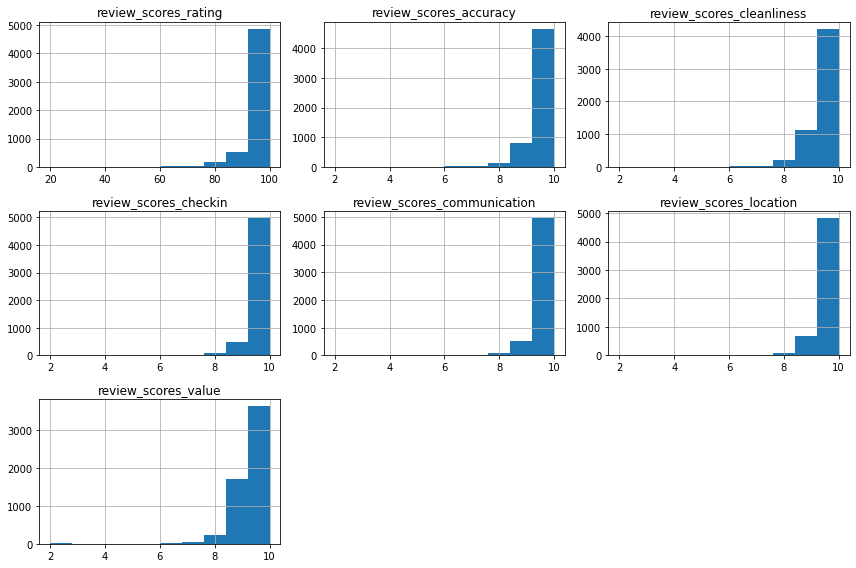

In [45]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(listing.columns[listing.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    listing[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [46]:
variables_to_plot.pop(0) #only keep the ones with max score 10
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')
    
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [47]:
for col in variables_to_plot:
    listing[col].fillna('no reviews', inplace=True)

#### cancellation_policy

In [48]:
listing.cancellation_policy.value_counts()

strict_14_with_grace_period    2476
moderate                       2324
flexible                       1681
super_strict_30                  47
super_strict_60                  46
strict                            1
Name: cancellation_policy, dtype: int64

In [49]:
listing.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
}, inplace=True)

#### number_of_reviews_ltm and reviews_per_month
They are highly correlated with number_of_reviews and so will be dropped

In [50]:
listing.drop('number_of_reviews_ltm', axis=1, inplace=True)

In [51]:
listing.dropna(subset=['host_since'], inplace=True)

In [52]:
listing.reviews_per_month.fillna(0, inplace=True)

In [53]:
listing.host_is_superhost.replace(to_replace = dict(t = 1, f = 0), inplace = True)
listing.has_availability.replace(to_replace = dict(t = 1, f = 0), inplace = True)
listing.instant_bookable.replace(to_replace = dict(t = 1, f = 0), inplace = True)

In [54]:
listing.head()

,listing_url,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,has_availability,availability_30,availability_365,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month,host_day_active,num_amenities,check_in_24h,air_conditioning,bbq,balcony,bed_linen,tv,coffee_machine,cooking_basics,dishwasher,elevator,gym,child_friendly,parking,outdoor_space,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,time_since_first_review,time_since_last_review
0,https://www.airbnb.com/rooms/2318,2318,2008-08-26,within an hour,50-89%,1,2.0,Madrona,47.61082,-122.29082,House,Entire home/apt,9,2.5,4.0,4.0,296.0,500.0,250.0,8,25.0,1,1125,1,0,30,32,2008-09-15,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,1,strict_14_with_grace_period,0.22,4316.0,39,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,5+ years,2-6 months
1,https://www.airbnb.com/rooms/9419,9419,2009-08-09,within a few hours,100%,1,8.0,Georgetown,47.55017,-122.31937,Apartment,Private room,2,3.0,1.0,2.0,62.0,100.0,20.0,1,15.0,2,180,1,30,365,148,2010-07-30,80-94/100,10/10,10/10,10/10,10/10,10/10,10/10,0,moderate,1.23,3968.0,37,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,5+ years,2-6 months
2,https://www.airbnb.com/rooms/9531,9531,2009-08-13,within a few hours,100%,1,2.0,Fairmount Park,47.55539,-122.38474,House,Entire home/apt,4,1.0,2.0,3.0,165.0,400.0,120.0,2,10.0,3,730,1,0,290,40,2012-01-12,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,strict_14_with_grace_period,0.39,3964.0,50,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5+ years,2-6 months
3,https://www.airbnb.com/rooms/9534,9534,2009-08-13,within a few hours,100%,1,2.0,Fairmount Park,47.55624,-122.38598,Other,Entire home/apt,3,1.0,2.0,2.0,125.0,400.0,95.0,2,5.0,2,365,1,1,293,50,2012-01-15,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,strict_14_with_grace_period,0.49,3964.0,48,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,5+ years,2-8 weeks
4,https://www.airbnb.com/rooms/9596,9596,2009-04-26,within a few hours,50-89%,0,5.0,Wallingford,47.65479,-122.33652,Apartment,Entire home/apt,4,1.0,1.0,4.0,120.0,200.0,85.0,2,15.0,30,60,1,8,56,93,2011-06-15,80-94/100,9/10,9/10,10/10,9/10,10/10,9/10,0,strict_14_with_grace_period,0.85,4073.0,31,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5+ years,6-12 months


In [55]:
from IPython.display import display
from ipywidgets import widgets
X = listing.drop('price', axis=1)
y = listing['price']

def listing_plot(X, y):
    def plotter(column):
        valid_rows = X[column].notna()
        plt.plot(X.loc[valid_rows, column], y[valid_rows], '.', color='k')
        #plt.xlabel(column)
        #plt.ylabel('List price ($)')
        plt.figure(figsize = (20,10))
    return plotter

dropdown_values = {"{0}".format(k) for k in X.columns}
widgets.interact(listing_plot(X, y), column=dropdown_values);

interactive(children=(Dropdown(description='column', options=('tv', 'property_type', 'private_entrance', 'revi…

## EDA
### Numerical features

In [56]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6574 entries, 0 to 6574
Data columns (total 62 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   listing_url                  6574 non-null   object        
 1   id                           6574 non-null   int64         
 2   host_since                   6574 non-null   datetime64[ns]
 3   host_response_time           6574 non-null   object        
 4   host_response_rate           6574 non-null   object        
 5   host_is_superhost            6574 non-null   int64         
 6   host_total_listings_count    6574 non-null   float64       
 7   neighbourhood_cleansed       6574 non-null   object        
 8   latitude                     6574 non-null   float64       
 9   longitude                    6574 non-null   float64       
 10  property_type                6574 non-null   object        
 11  room_type                    6574 non-null 

#### Price distribution

In [57]:
listing[listing.price > 500].shape[0] / listing.price.shape[0]

0.025250988743535138

In [58]:
print('Nightly advertised prices range from {}'.format(min(listing.price)), 'to {}'.format(max(listing.price)))

Nightly advertised prices range from 0.0 to 10000.0


Text(0.5, 0, 'Price')

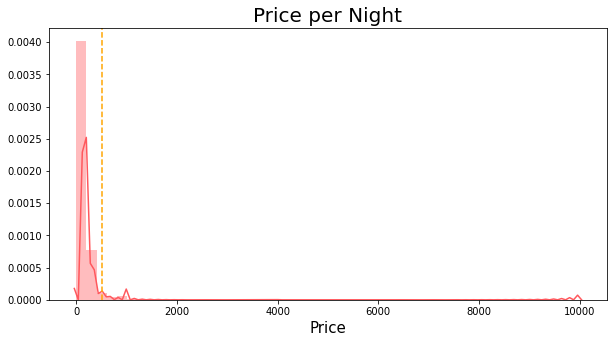

In [59]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.distplot(listing['price'], color = '#FF585D')
plt.axvline(500, color='orange', linestyle='--')
ax.set_title('Price per Night', fontsize = 20)
ax.set_xlabel('Price', fontsize = 15)

Text(0.5, 0, 'Price')

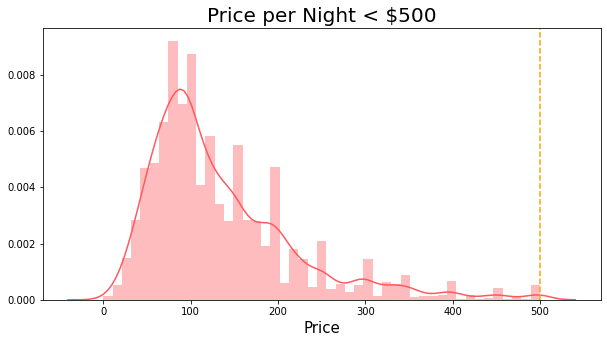

In [60]:
# Distribution of prices from $500 upwards
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.distplot(listing[listing['price']<=500]['price'], color = '#FF585D')
plt.axvline(500, color='orange', linestyle='--')
#plt.axvline(1050, color='red', linestyle='--')
ax.set_title('Price per Night < $500', fontsize = 20)
ax.set_xlabel('Price', fontsize = 15)

In [61]:
# Drop rows with price >= $500
listing = listing[listing['price'] <= 500]

#### San Francisco Model

**Estimated Monthly Bookings = (# Of Reviews Per Month / Review Rate)**

**# Of Booked Days Per Month = Avg Length of Stay * Estimated Monthly Bookings**

**Monthly Revenue = # of Booked Days Per Month * Daily Price**

Text(0.5, 1.0, 'Distribution of Reviews per Month')

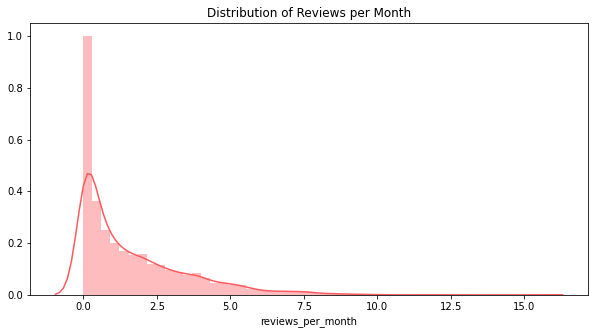

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.distplot(listing['reviews_per_month'], color='#FF585D')
ax.set_title("Distribution of Reviews per Month")

In [63]:
listing['reviews_per_month'].shape

(6408,)

In [64]:
listing[listing['reviews_per_month'] <= 10].shape

(6402, 62)

In [65]:
review_rate = 0.5
avg_lenth_stay = 3

monthly_bookings = np.array(listing['reviews_per_month'] / review_rate)
booked_days_month = np.minimum(30, avg_lenth_stay * monthly_bookings)
listing['booked_days'] = booked_days_month
listing['monthly_revenue'] = booked_days_month * listing['price']

Text(0.5, 1.0, 'Number of Booked Days Per Month')

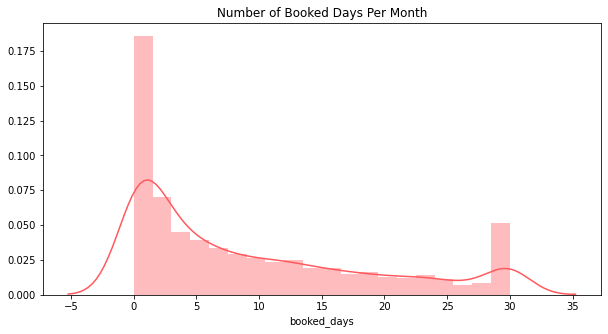

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.distplot(listing['booked_days'], color='#FF585D')
ax.set_title("Number of Booked Days Per Month")

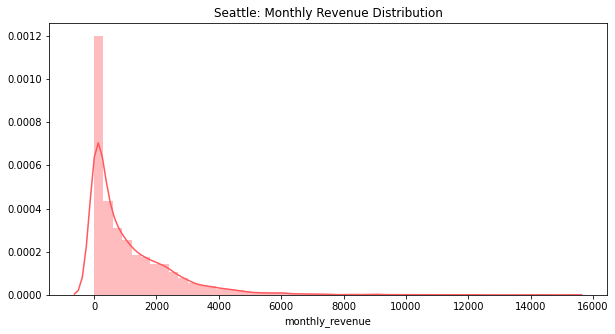

In [67]:
fig, ax = plt.subplots(figsize=(10,5)) 
ax = sns.distplot(listing['monthly_revenue'], color='#FF585D')
ax.set_title('Seattle: Monthly Revenue Distribution');

#### Host listings count
Questions: how many listings do hosts have on average? How many multi-listing hosts are there?

In [68]:
print('Median # of listings/host: {}'.format(listing.host_total_listings_count.median()))
print('Mean # of listings/host: {}'.format(listing.host_total_listings_count.mean()))
print('Listings from hosts with one listing: {}%'.format(int(round(100*len(listing[listing.host_total_listings_count == 1])/len(listing)))))


Median # of listings/host: 2.0
Mean # of listings/host: 96.76061173533084
Listings from hosts with one listing: 40%


#### Number of guests accomodated, bathrooms, bedrooms and beds
Question: what are the average number of people accommodated, bathrooms, bedrooms and beds in Airbnb listings in Seattle, and how do prices differ?

Answer: the most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher nightly rates, with diminishing returns coming after about 10 people.

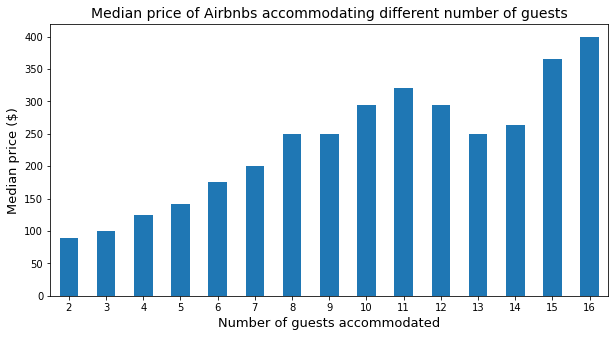

In [69]:
plt.figure(figsize=(10,5))
listing.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

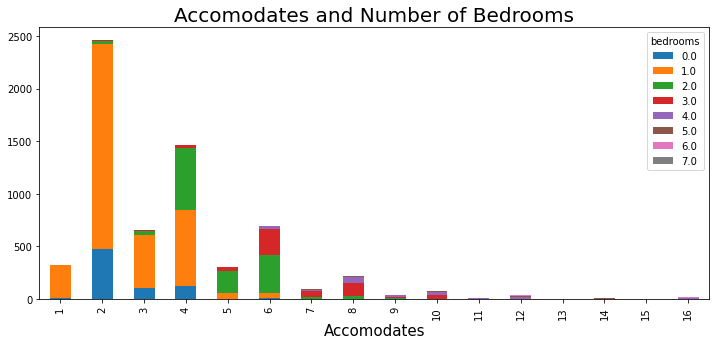

In [70]:
model1_plot = listing.groupby(['accommodates', 'bedrooms']).size().reset_index().pivot(columns='bedrooms',
                                                                                  index='accommodates', values=0)

model1_plot.plot(kind='bar', stacked=True, figsize=(12,5))
plt.title("Accomodates and Number of Bedrooms", size=20)
plt.xlabel("Accomodates", size=15);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6415be340>,
      dtype=object)

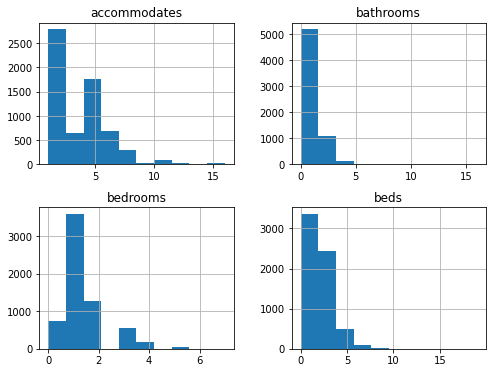

In [71]:
listing[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6))

### Categorical features
Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

#### Neighbourhood
Question: which areas have the most Airbnb properties, and which are the most expensive?

In [72]:
# Renaming the neighbourhood column
listing.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

In [73]:
geo.head()

,neighbourhood,neighbourhood_group,geometry
0,Wallingford,Other neighborhoods,"MULTIPOLYGON (((-122.34731 47.66501, -122.3464..."
1,West Queen Anne,Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569..."
2,Adams,Ballard,"MULTIPOLYGON (((-122.37634 47.67592, -122.3762..."
3,West Woodland,Ballard,"MULTIPOLYGON (((-122.37634 47.67592, -122.3760..."
4,East Queen Anne,Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569..."


In [74]:
borough_df = pd.DataFrame(listing.groupby('borough').size())
borough_df.rename(columns={0:'number_of_listings'}, inplace=True)
borough_df['median_price'] = listing.groupby('borough').price.median().values

In [75]:
# Joining the dataframes
borough_map_df = geo.set_index('neighbourhood').join(borough_df)

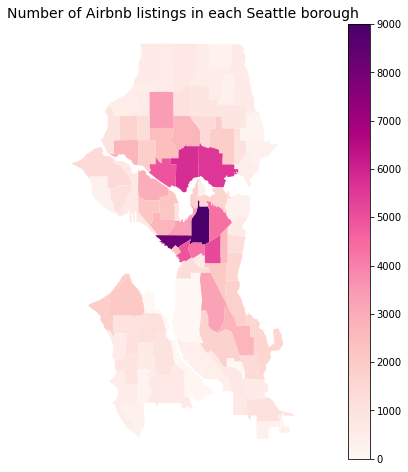

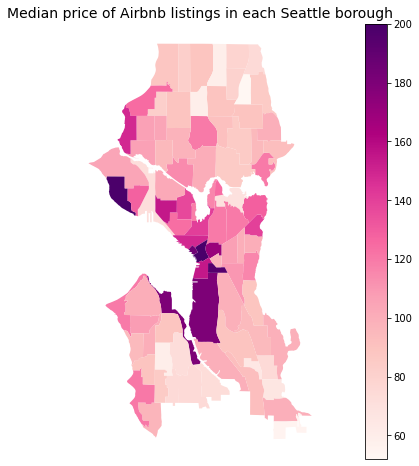

In [76]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize = (15, 8))
borough_map_df.plot(column='number_of_listings', cmap='RdPu', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Seattle borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1,figsize = (15, 8))
borough_map_df.plot(column='median_price', cmap= 'RdPu', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Seattle borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='RdPu', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

#### Property and room_types

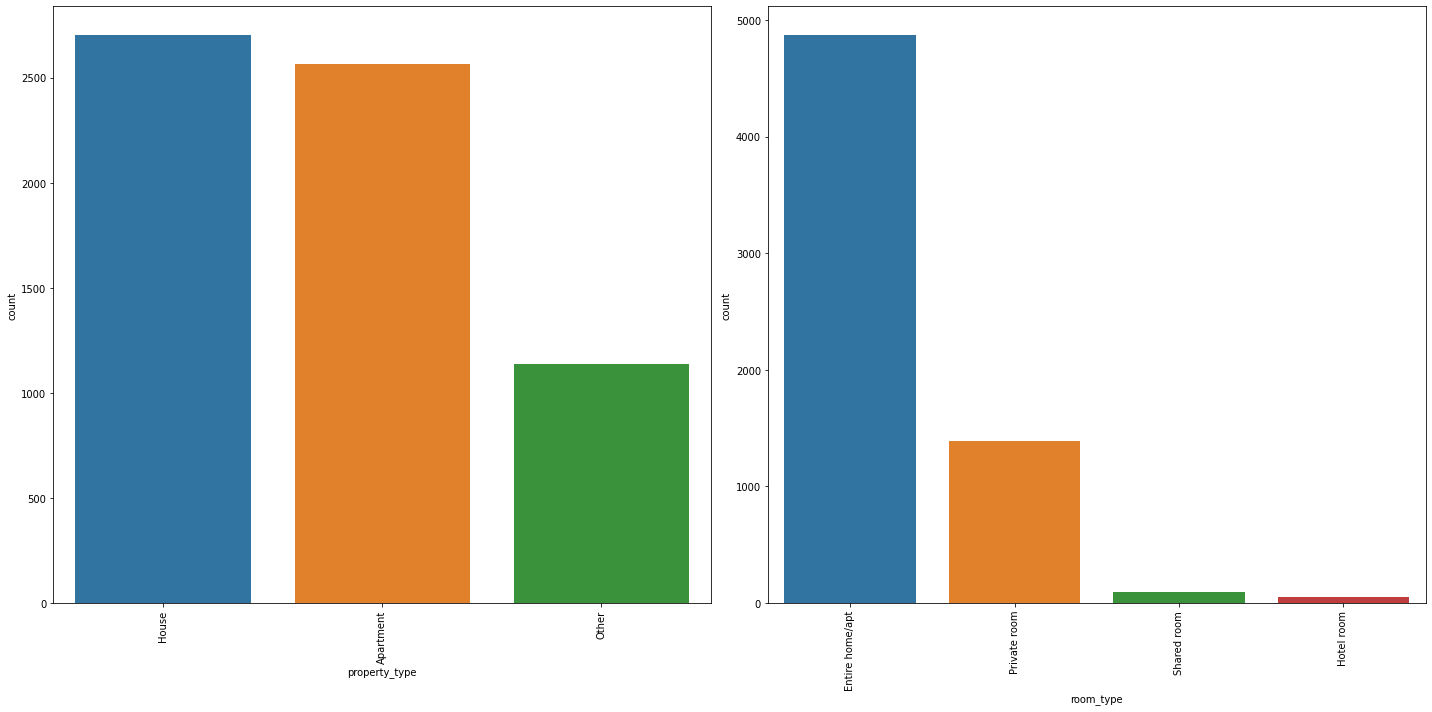

In [77]:
plt.figure(figsize=(20, 10))

for i, col in enumerate(['property_type', 'room_type'], 1):
    plt.subplot(1, 2, i)
    g = sns.countplot(x=col, data=listing)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.xlabel(f'{col}')  
plt.tight_layout()
plt.show()

#### Reviews
Questions: what's the distribution of reviews like?

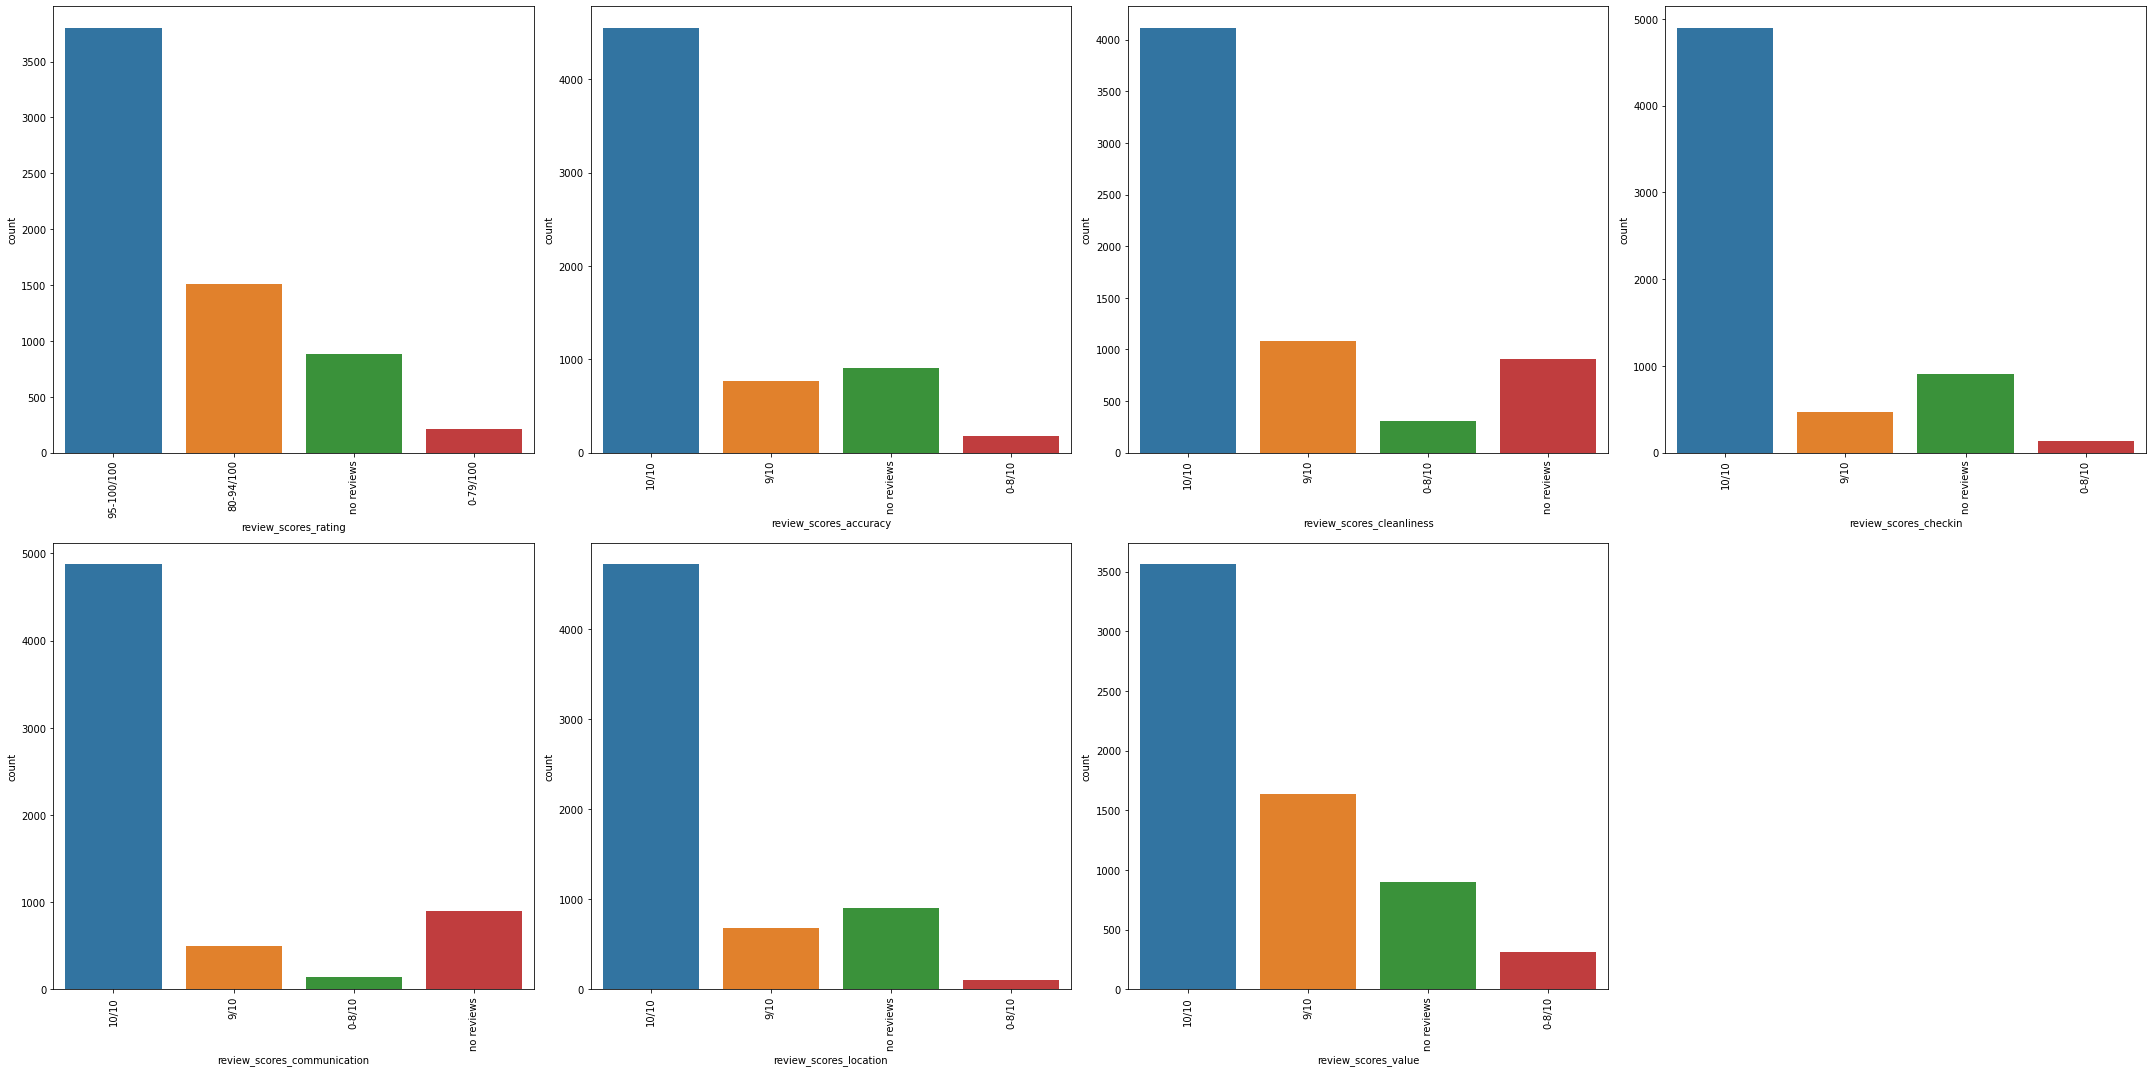

In [78]:
plt.figure(figsize=(30, 15))

for i, col in enumerate(['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value'], 1):
    plt.subplot(2, 4, i)
    g = sns.countplot(x=col, data=listing)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.xlabel(f'{col}')  
plt.tight_layout()
plt.show()

#### First and last reviews
Question: how long have listings been on site, and how many listings have been reviewd recently?

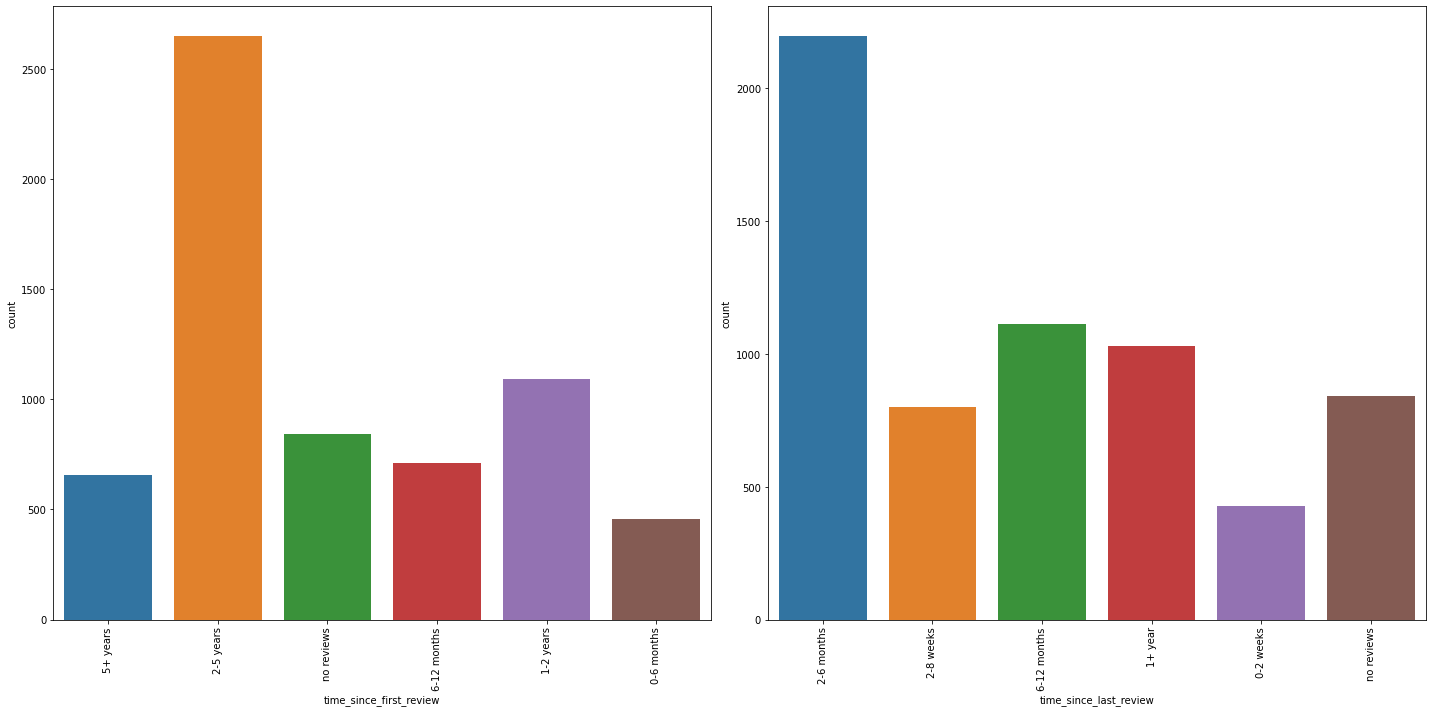

In [79]:
plt.figure(figsize=(20, 10))

for i, col in enumerate(['time_since_first_review', 'time_since_last_review'], 1):
    plt.subplot(1, 2, i)
    g = sns.countplot(x=col, data=listing)
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.xlabel(f'{col}')  
plt.tight_layout()
plt.show()

#### Superhosts, instant booking

In [80]:
def pairplot(col):
    sns.set(font_scale=2)
    fig, axes = plt.subplots(1, 2, figsize= [10,5])
    listing.groupby(col).size().plot(kind='bar', color = sns.color_palette(), ax=axes[0])
    axes[0].set_title('Category Count')

    listing.groupby(col).price.median().plot(kind='bar', color = sns.color_palette(), ax=axes[1])
    axes[1].set_title('Median Price $')
    plt.tight_layout()
    plt.show()

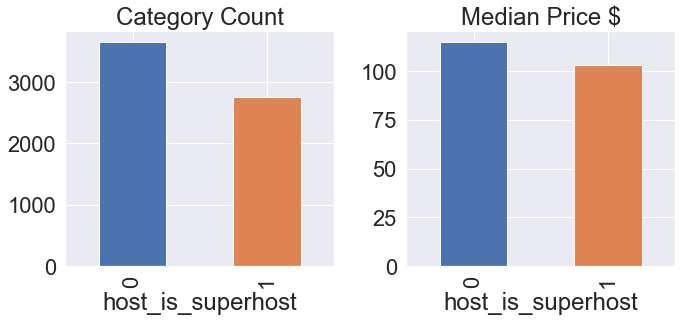

In [81]:
pairplot('host_is_superhost')

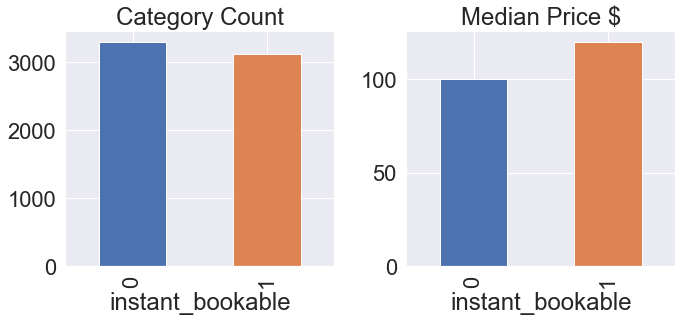

In [82]:
pairplot('instant_bookable')

#### Amenities
Uncommon, but with is have a higher median price:
- check_in_24h
- air conditioning
- bbq
- balcony
- elevator
- gym
- child_friendly
- secure

Most properties have them, and have a higher price:
- self_check_in
- private_entrance
- internet
- dishwasher
- cooking_basics
- coffee_machine
- tv

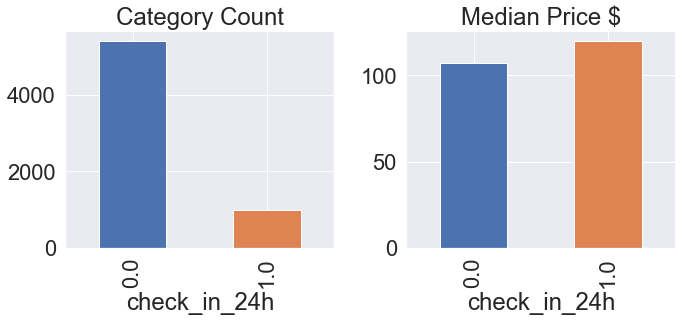

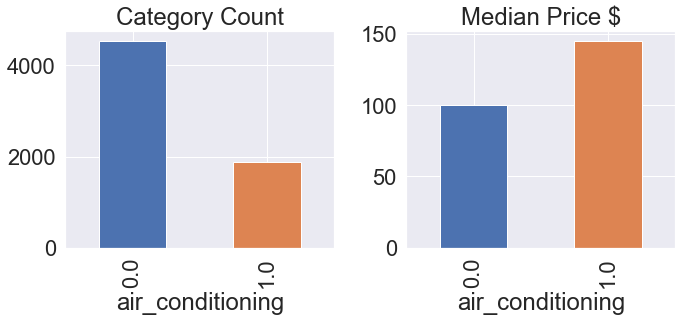

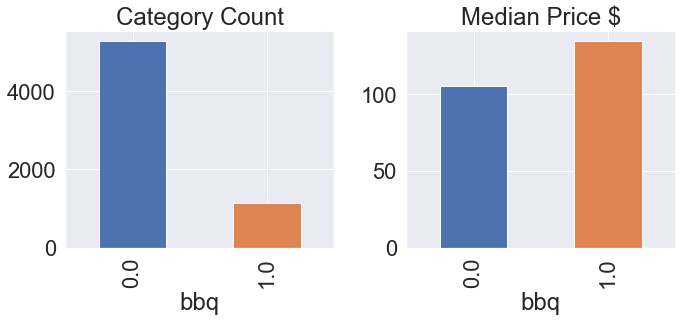

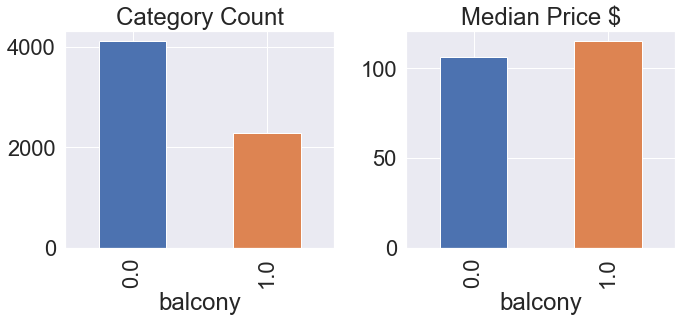

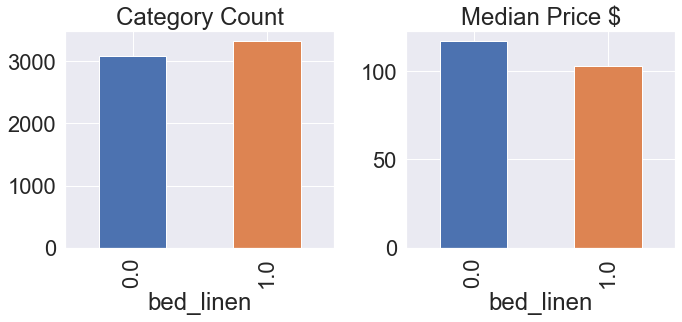

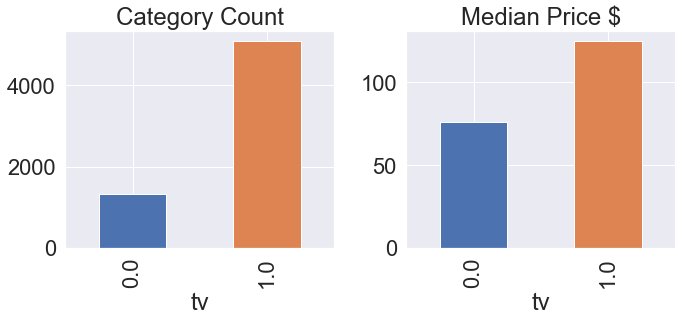

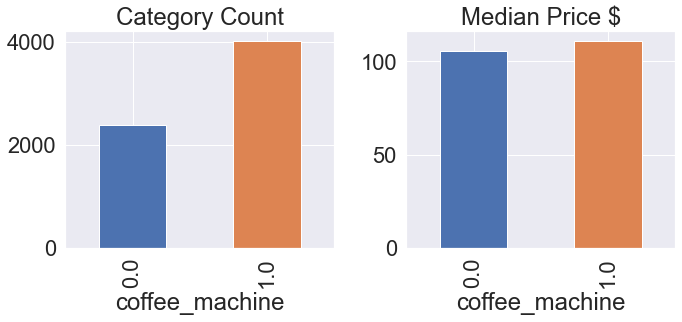

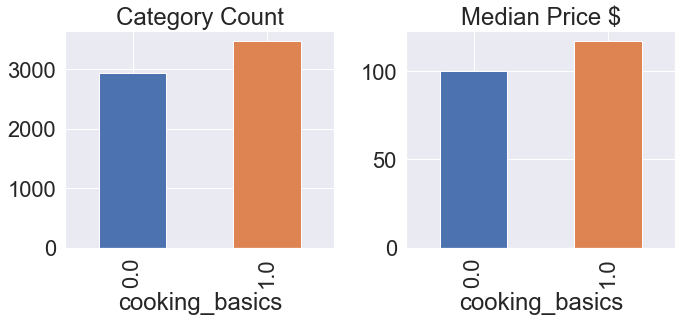

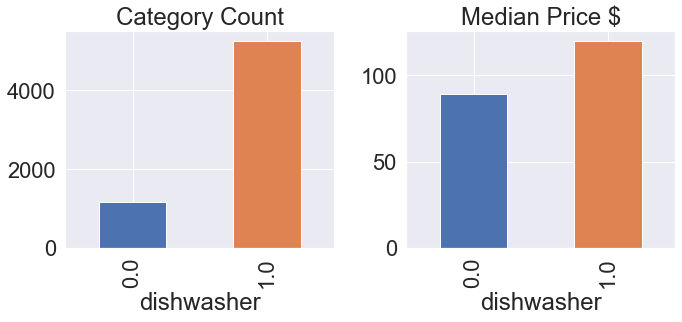

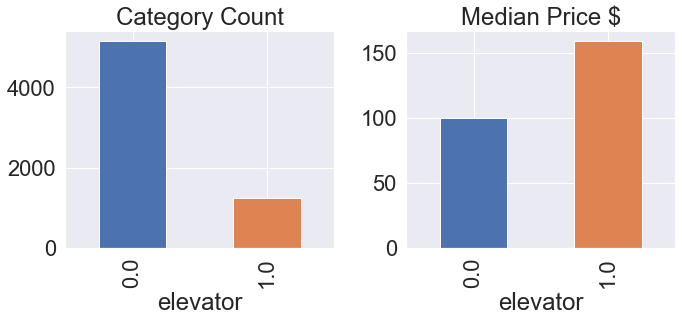

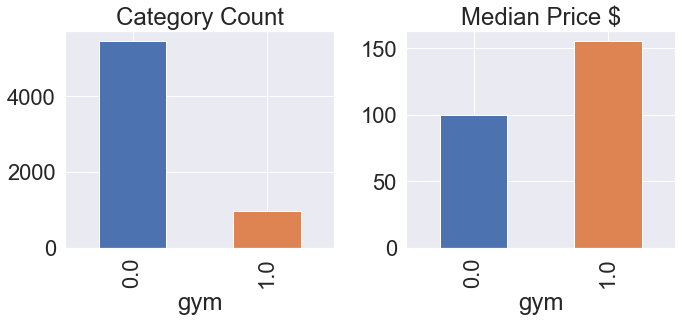

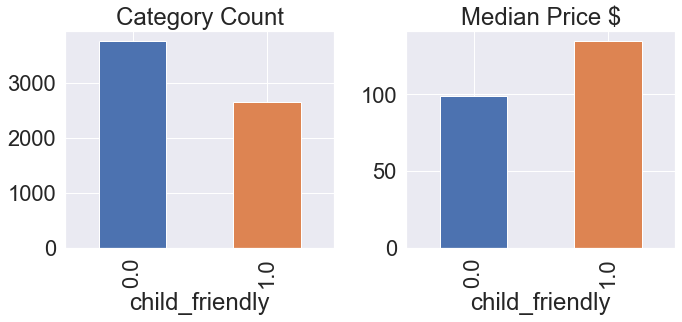

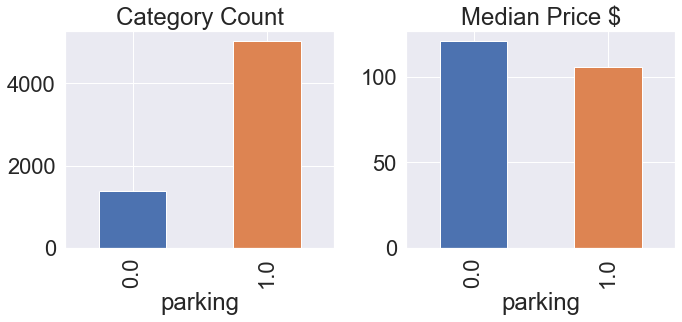

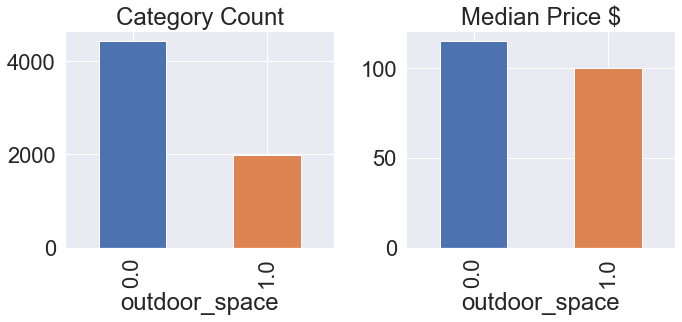

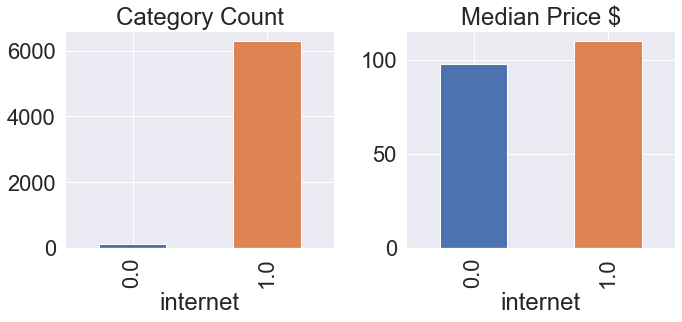

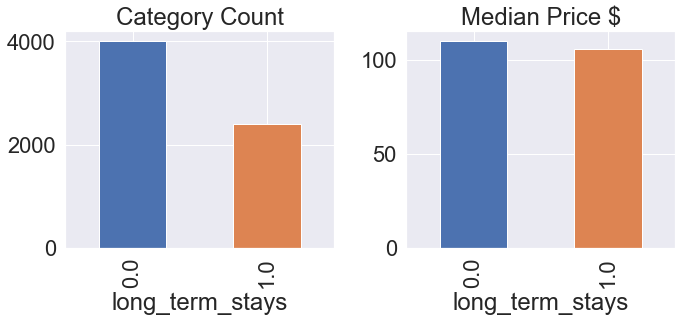

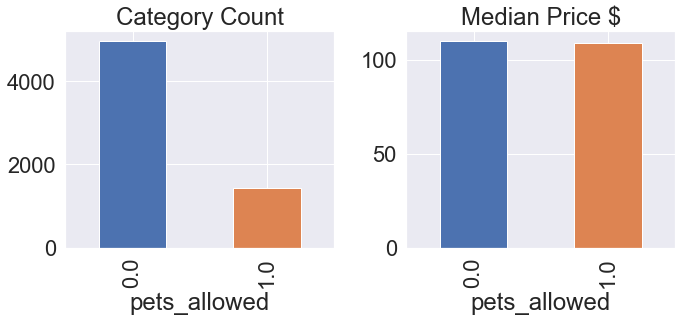

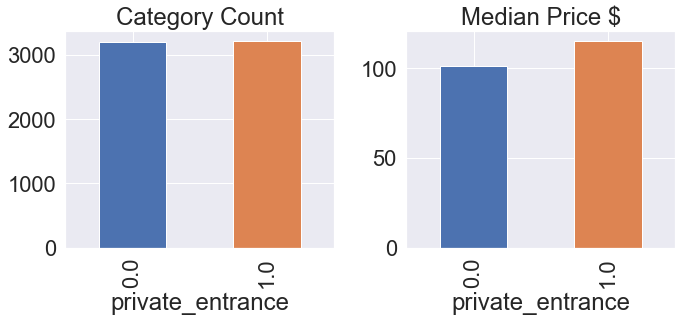

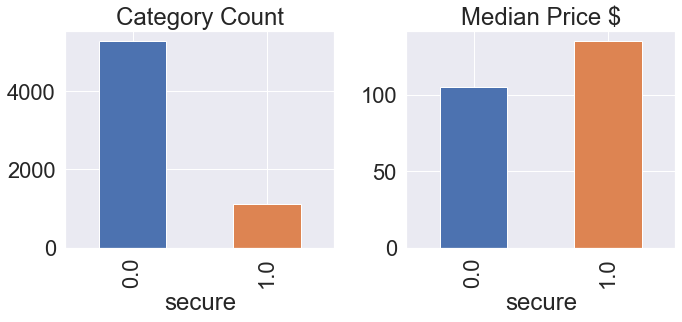

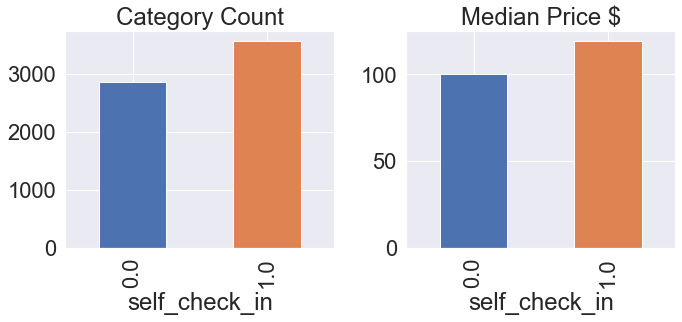

In [83]:
for col in listing.iloc[:, 40:60].columns:
    pairplot(col)

In [84]:
listing.head()

,listing_url,id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,borough,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,has_availability,availability_30,availability_365,number_of_reviews,first_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month,host_day_active,num_amenities,check_in_24h,air_conditioning,bbq,balcony,bed_linen,tv,coffee_machine,cooking_basics,dishwasher,elevator,gym,child_friendly,parking,outdoor_space,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,time_since_first_review,time_since_last_review,booked_days,monthly_revenue
0,https://www.airbnb.com/rooms/2318,2318,2008-08-26,within an hour,50-89%,1,2.0,Madrona,47.61082,-122.29082,House,Entire home/apt,9,2.5,4.0,4.0,296.0,500.0,250.0,8,25.0,1,1125,1,0,30,32,2008-09-15,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,1,strict_14_with_grace_period,0.22,4316.0,39,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,5+ years,2-6 months,1.32,390.72
1,https://www.airbnb.com/rooms/9419,9419,2009-08-09,within a few hours,100%,1,8.0,Georgetown,47.55017,-122.31937,Apartment,Private room,2,3.0,1.0,2.0,62.0,100.0,20.0,1,15.0,2,180,1,30,365,148,2010-07-30,80-94/100,10/10,10/10,10/10,10/10,10/10,10/10,0,moderate,1.23,3968.0,37,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,5+ years,2-6 months,7.38,457.56
2,https://www.airbnb.com/rooms/9531,9531,2009-08-13,within a few hours,100%,1,2.0,Fairmount Park,47.55539,-122.38474,House,Entire home/apt,4,1.0,2.0,3.0,165.0,400.0,120.0,2,10.0,3,730,1,0,290,40,2012-01-12,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,strict_14_with_grace_period,0.39,3964.0,50,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,5+ years,2-6 months,2.34,386.10
3,https://www.airbnb.com/rooms/9534,9534,2009-08-13,within a few hours,100%,1,2.0,Fairmount Park,47.55624,-122.38598,Other,Entire home/apt,3,1.0,2.0,2.0,125.0,400.0,95.0,2,5.0,2,365,1,1,293,50,2012-01-15,95-100/100,10/10,10/10,10/10,10/10,10/10,10/10,0,strict_14_with_grace_period,0.49,3964.0,48,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,5+ years,2-8 weeks,2.94,367.50
4,https://www.airbnb.com/rooms/9596,9596,2009-04-26,within a few hours,50-89%,0,5.0,Wallingford,47.65479,-122.33652,Apartment,Entire home/apt,4,1.0,1.0,4.0,120.0,200.0,85.0,2,15.0,30,60,1,8,56,93,2011-06-15,80-94/100,9/10,9/10,10/10,9/10,10/10,9/10,0,strict_14_with_grace_period,0.85,4073.0,31,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,5+ years,6-12 months,5.10,612.00


## Preparing the data for modeling
#### Dropping columns and assessing multi-collinearity

In [85]:
col_todrop = ['host_since', 'latitude', 'longitude', 
              'has_availability', 'availability_365', 'first_review', 'reviews_per_month', 'booked_days', 'monthly_revenue']
df = listing.drop(col_todrop, axis=1)

In [86]:
transformed_df = pd.get_dummies(df)

In [87]:
def multi_coli(df):
    sns.set(style="white")
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize = [25,25])
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=0.5, 
                cbar_kws={'shrink': 0.5}, vmax=corr[corr != 1.0].max().max())
    plt.show

In [ ]:
multi_coli(transformed_df)

Remove borough related features

In [ ]:
multi_coli(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1))

In [ ]:
# Dropping collinear features
to_drop = ['beds', 'guests_included', 'host_response_rate_unknown', 'host_response_rate_0-49%']

In [ ]:
transformed_df.drop(to_drop, axis=1, inplace=True)

In [ ]:
transformed_df.head()

In [86]:
df = df.drop(['beds', 'guests_included'], axis=1)

In [87]:
df.to_pickle('data_similarlisting.pkl')

In [ ]:
df = df.drop(['listing_url', 'id'], axis = 1)

In [1097]:
df.to_pickle('processed_data.pk1')

In [89]:
airbnb_listing = pd.DataFrame({'Year': ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'], 'Listings': [0.12, 0.3, 0.8, 1.2, 2.1, 4, 6, 7, 7.7]})

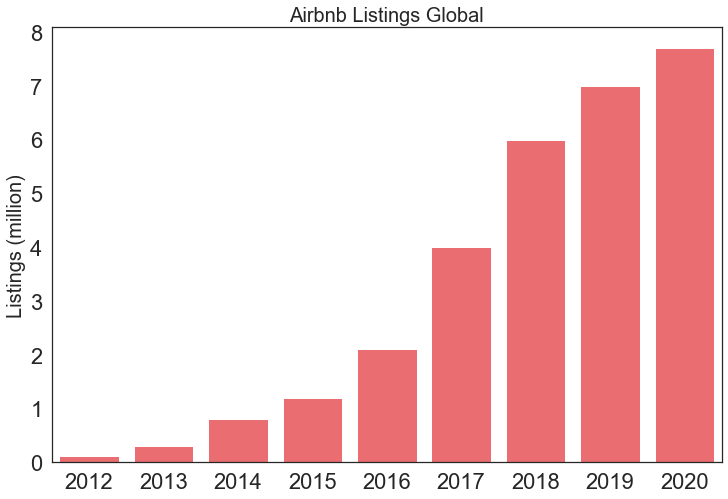

In [108]:
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x = 'Year', y= 'Listings', data = airbnb_listing, color = '#FF585D')
ax.set(xlabel=None)
#plt.axvline(1050, color='red', linestyle='--')
plt.title('Airbnb Listings Global', size = 20)
plt.ylabel('Listings (million)', size = 20)
plt.savefig('listing_trend', bbox_inches ='tight', dpi = 400)

In [75]:
review2.groupby('listing_id').head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2318,146,2008-09-15,2451,Kevin,1000 times better than staying at a hotel.
1,2318,126302712,2017-01-10,12332845,Jessica,"Our family (two couples, a two year old and an..."
2,2318,140977084,2017-04-01,4789466,Ivan,Top of the list locations we have stayed at! T...
3,2318,147262504,2017-04-25,55817131,Mike,"SUCH an awesome place. Very clean, quiet and s..."
4,2318,161806368,2017-06-18,113604590,Pete,We flew quite a distance to be at our only dau...
...,...,...,...,...,...,...
366246,43554849,629318597,2020-06-13,149601627,Victor,Was hassled over a service dog as well as a ru...
366247,43589616,628347984,2020-06-07,329835778,Devon,Very nice to stay. 100% would recommend to any...
366248,43589616,629679135,2020-06-14,348816568,Darryl,The only real bad thing I have to say about th...
366249,43603849,628296245,2020-06-07,348375439,Birat,Best view in town .


In [37]:
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2318,2020-06-17,f,$243.00,$243.00,1.0,1125.0
1,132160,2020-06-17,f,$75.00,$75.00,2.0,1125.0
2,132160,2020-06-18,f,$75.00,$75.00,2.0,1125.0
3,132160,2020-06-19,f,$100.00,$100.00,2.0,1125.0
4,132160,2020-06-20,f,$100.00,$100.00,2.0,1125.0


In [35]:
neighbour.head()

,neighbourhood_group,neighbourhood
0,Ballard,Adams
1,Ballard,Loyal Heights
2,Ballard,Sunset Hill
3,Ballard,West Woodland
4,Ballard,Whittier Heights


In [27]:
geo.head()

,neighbourhood,neighbourhood_group,geometry
0,Wallingford,Other neighborhoods,"MULTIPOLYGON (((-122.34731 47.66501, -122.3464..."
1,West Queen Anne,Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569..."
2,Adams,Ballard,"MULTIPOLYGON (((-122.37634 47.67592, -122.3762..."
3,West Woodland,Ballard,"MULTIPOLYGON (((-122.37634 47.67592, -122.3760..."
4,East Queen Anne,Queen Anne,"MULTIPOLYGON (((-122.35692 47.63959, -122.3569..."


In [34]:
parking.head()

,OccupancyDateTime,PaidOccupancy,BlockfaceName,SideOfStreet,SourceElementKey,ParkingTimeLimitCategory,ParkingSpaceCount,PaidParkingArea,PaidParkingSubArea,PaidParkingRate,ParkingCategory,Location
0,03/25/2020 01:43:00 PM,1,BELL ST BETWEEN 1ST AVE AND 2ND AVE,SE,32022,120.0,4,Belltown,South,NaN,Paid Parking,POINT (-122.34597326 47.61368424)
1,03/25/2020 06:36:00 PM,1,SPRING ST BETWEEN 8TH AVE AND 9TH AVE,SE,58186,120.0,8,First Hill,NaN,NaN,Paid Parking,POINT (-122.3285232 47.60883822)
2,03/25/2020 01:46:00 PM,1,E PINE ST BETWEEN MELROSE AVE AND BELLEVUE AVE,S,59994,120.0,8,Pike-Pine,NaN,NaN,Paid Parking,POINT (-122.32733505 47.61514566)
3,03/25/2020 01:22:00 PM,2,24TH AVE NW BETWEEN NW MARKET ST AND NW 56TH ST,E,48770,240.0,6,Ballard,Edge,NaN,Paid Parking,POINT (-122.38743204 47.66909241)
4,03/25/2020 09:09:00 AM,1,WESTERN AVE BETWEEN LENORA ST AND BLANCHARD ST,NE,58810,120.0,10,Belltown,South,NaN,Paid Parking,POINT (-122.34538208 47.61161729)
